<a href="https://colab.research.google.com/github/ClementBM/Experiment_DeepLearning_Moonboard_Grade-Prediction/blob/master/LSTM_BoulderProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import some relevant packages
Here, we import some common packages and Keras packages related with LSTM RNN

In [0]:
# Keras packages and related with LSTM RNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# Common packages
from pandas import read_csv
import json
from matplotlib import pyplot
import matplotlib.cm as cm
import math
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import collections
import pandas as pd

### Load and parse data
I scrapped little bits of data from the moonboard official website (hoped they don't bother.. ). The data is formatted as json files. Each file is named with the grade difficulty. In this step, I also calculate the distance between holds.

In [0]:
# used for holds serialization as one-hot vector
abcIndex = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
# used for grade serialization as an integer ordinal (?) scale
gradeIndex = ['6A+', '6B', '6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+']

dataFiles = [f for f in listdir("sample_data") if isfile(join("sample_data", f))]

boulderProblemsCategoricalMoves = []
boulderProblemsOneHotVectMoves = []
boulderProblemsDistances = []
boulderProblemsMovesAndDistances = []
bGrades = []
  
for dataFile in dataFiles:
  bProblemsPath = os.path.join("sample_data", dataFile)
  bGrade = dataFile.replace(".json","")
  bGradeIndex = gradeIndex.index(bGrade)
  gradeHotOne = [0] * len(gradeIndex)
  gradeHotOne[bGradeIndex] = 1
  
  with open(bProblemsPath) as jsonData:
      jsonRaw = jsonData.read()
      boulderProblems5 = json.loads(jsonRaw)

  exCount = len(boulderProblems5['Data'])

  eobVect = [0] * 199
  eobVect[198] = 1

  for i in range(0, exCount):
    moves = boulderProblems5['Data'][i]['Moves']
    moveCount = len(moves)
    boulderProblemOneHotVectMoves = []
    boulderProblemCategoricalMoves = []
    
    holdLocations = boulderProblems5['Data'][i]['Locations']
    holdCount = len(holdLocations)
    distances = []
    
    if(moveCount != holdCount):
      print("moveCount != holdCount")
    
    for j in range(0, moveCount):
      ## Get Hold Index
      hold = moves[j]['Description']
      boulderProblemCategoricalMoves.append(hold)
      
      letterIndex = abcIndex.index(hold[0])
      number = int(hold[1:])
      hotOneVect = [0] * 199 # 199 (distance)
      hotOneVect[((letterIndex * 18) + number - 1)] = 1
      boulderProblemOneHotVectMoves.append(hotOneVect)
      
      ## Get distance
      currentHoldLocation = holdLocations[j]
      if(j == 0):
        distances.append([0, 0, 0])
      else:
        oldHoldLocation = holdLocations[j-1]
        xDistance = currentHoldLocation['X'] - oldHoldLocation['X']
        yDistance = currentHoldLocation['Y'] - oldHoldLocation['Y']
        distance = math.sqrt(xDistance**2 + yDistance**2)
        distances.append([xDistance, yDistance, distance])
      ##
      
    # Add End Of Boulder vector
    boulderProblemOneHotVectMoves.append(eobVect)
    boulderProblemCategoricalMoves.append("EOB")
    distances.append([0, 0, 0])
    
    # Distances and Holds
    boulderProblemsDistances.append(distances)
    boulderProblemsCategoricalMoves.append(boulderProblemCategoricalMoves)
    boulderProblemsOneHotVectMoves.append(boulderProblemOneHotVectMoves)
    distancesNorm = np.divide(distances, 100) # arbitrary scaling
    boulderProblemsMovesAndDistances.append(np.concatenate((boulderProblemOneHotVectMoves, distancesNorm), axis=1))

    # y
    bGrades.append(bGradeIndex)

### Look at the data
Just a brief look at the data. We have distances - numerical data - and hold names - categorical data. In the following parts we use the one-hot vectors created from hold names. We add the numerical to the one-hot vector, ugly method waiting for a way to combine numerical and categorical variables in neural network.

In [25]:
# display descriptive statistics
distancesFlat = pd.DataFrame([y for x in boulderProblemsDistances for y in x])
holdsFlat = pd.DataFrame([x for x in boulderProblemsCategoricalMoves])

print(distancesFlat.head())
print(holdsFlat.head())

display(distancesFlat.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))
display(holdsFlat.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

,0,1,2
count,9133.000000,9133.000000,9133.000000
mean,38.809811,4.065696,231.500410
std,47.045149,298.290162,197.774761
min,0.000000,-852.000000,0.000000
25%,0.000000,-200.000000,50.039984
50%,50.000000,0.000000,204.215572
75%,50.000000,200.000000,351.573605
85%,100.000000,300.000000,450.781544
95%,150.000000,500.000000,632.455532
99%,200.000000,700.000000,750.000000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,1089,1089,1089,1089,1089,1077,1001,798,487,208,82,23,7,3,2
unique,130,151,146,160,160,155,141,118,74,50,21,8,3,3,1
top,F5,H5,G8,H10,G13,EOB,EOB,EOB,EOB,EOB,EOB,EOB,EOB,EOB,EOB
freq,127,56,51,56,80,76,203,311,279,126,59,16,4,1,2


     0    1           2
0    0    0    0.000000
1  150  148  210.722566
2  100  150  180.277564
3  200  300  360.555128
4   50 -148  156.217797
    0    1    2    3    4    5     6     7     8     9     10    11    12  \
0   J6   K9  F12  D15  A18  EOB  None  None  None  None  None  None  None   
1  E14  F11  F10  H18   K3   K5    K9   EOB  None  None  None  None  None   
2   D3   F3   G8  D12  E14  A18   EOB  None  None  None  None  None  None   
3   E4  E12   G7  H18   H3  J14   EOB  None  None  None  None  None  None   
4   D5   I5  H11  H12  H15  K16   G18   EOB  None  None  None  None  None   

     13    14  
0  None  None  
1  None  None  
2  None  None  
3  None  None  
4  None  None  


### Prepare the data for feeding the RNN.
* Padding X data because it has irregular length.
* Convert X and y to numpy array.

In [0]:
maxLength = max([len(s) for s in boulderProblemsMovesAndDistances])
X = np.array(boulderProblemsMovesAndDistances)
Xpad = pad_sequences(X, maxlen=maxLength, padding='post')

y = np.array(bGrades)

### Spliting the data
Split into train and test sets

In [27]:
RANDOM_SEED = 5
X_train, X_test, y_train, y_test = train_test_split(Xpad, y, test_size=0.2, random_state=RANDOM_SEED)

print("X_train")
print(X_train.shape)
print("X_test")
print(X_test.shape)
print(y_test)

X_train
(871, 15, 202)
X_test
(218, 15, 202)
[ 5  3  6  1  5  5 10  8  3  1  3  5  6  2  7  2  7  3  5  8  0  1  2  2
  8  7  9  8  1  8  7  0  2  0  1  5  5  0  0  3  5  1  0  2  6  1  3  2
  9  3  9  5  3  0  9  5  0  1  9  0 10  7  9  1 10  7  7  2  9  7  2  9
  6  3  3  9  6  8  8  1  7  4  9  6  3  9  7  8  2  9  4  4  9  3  5  7
 10  2  3  0 10  2  0  5  8  2  5  3  2  7  4 10  3  4  4  3  7  8  5  7
 10  2  8  8  9  5  5  0  2  0  2  7  4  5  3  5  0  6  9  5  9  3  5  5
  9  4  5  6  0  5  8 10  5  6  7  4  0  4  0  7  4  8  7  4  9  8 10  2
  0  9  2  0  7  8  2  5  4  4  7  6  3  6  2  4  5  6  2  8  0  7 10  1
  3  1  4  4  1  0  1  5  8  5  0  7  3  4  6 10  6  3  9  4  3  3 10  5
  0  7]


### Building the model
Here we define the LSTM RNN.

In [0]:
# Model
model = Sequential()
# first hidden layer
model.add(LSTM(input_shape=(X_train.shape[1], X_train.shape[2]), units=50, return_sequences=True))
model.add(Dropout(0.2))
# second hidden layer
model.add(LSTM(20, return_sequences=False))
model.add(Dropout(0.2))
# 1 neuron in the output layer
model.add(Dense(10))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mae', optimizer='adam')

### Fitting the model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 15, 50)            50600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total para

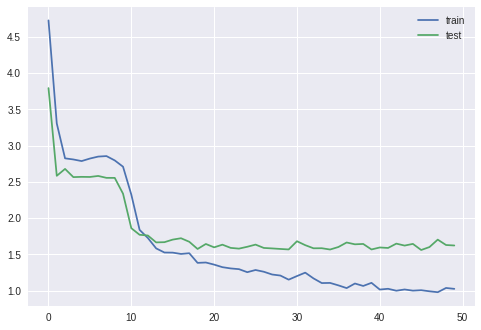

In [36]:
# fit network
history = model.fit(X_train, 
                    y_train, 
                    epochs=50,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    verbose=0, 
                    shuffle=False)
model.summary()

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluate Model
The best part !

We make predictions on the test set rounding the predicted grade floating number.

We then calculate the related MAE based on these prediction.

The grade error is shown in the heat map.

The absolute error is shown in the histogram.

218/218 [==============================] - 0s 177us/step
1.6212825643906899


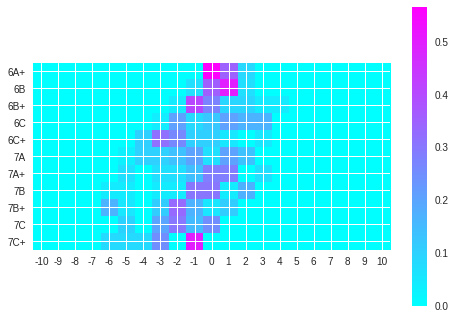

MAE = 1.5871559633027523
Correctness Count = {0} : [22.02%] + {1} : [35.32%] = 57.34%
First Bound Grade Error Count = {2} : [21.1%] + {3} : [12.84%] = 33.94%
Second Bound Grade Error Count = {4} : [3.21%] + {5} : [3.21%] + {6} : [2.29%] = 8.72%


[]

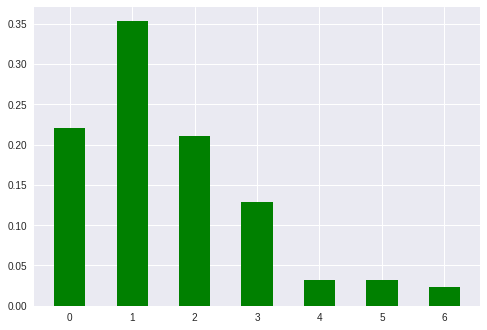

In [45]:
# make a prediction
print(model.evaluate(X_test, y_test,verbose=1))
# print(model.get_config())
# print(model.get_weights())

predictions = model.predict(X_test)
meanAbsError = 0
maeDifferences = []

errorByGrade = np.zeros((len(gradeIndex), len(gradeIndex) * 2 - 1))

for i in range(0, len(predictions)):
  prediction = predictions[i][0]
  roundedPrediction = int(round(prediction))
  diff = roundedPrediction - y_test[i]
  meanAbsError += abs(diff)
  maeDifferences.append(abs(diff))
  
  errorByGrade[y_test[i], diff + len(gradeIndex) - 1] += 1

errorByGradeRowSums = errorByGrade.sum(axis=1)
errorByGradeNorm = errorByGrade / errorByGradeRowSums[:, np.newaxis]

fig, ax = pyplot.subplots()
im = ax.imshow(errorByGradeNorm, cmap=cm.cool)
ax.figure.colorbar(im)

ax.set_xticks(np.arange(len(gradeIndex) * 2 - 1))
ax.set_xticklabels(np.arange(len(gradeIndex) * 2 - 1) - (len(gradeIndex) - 1))

ax.set_yticks(np.arange(len(gradeIndex)))
ax.set_yticklabels(gradeIndex)
pyplot.show()

print("MAE = {}".format(meanAbsError / len(predictions)))

maeDiffDictionnary = collections.Counter(maeDifferences)
maeDiffDictionnary = collections.OrderedDict(sorted(maeDiffDictionnary.items()))
maeDiffKeyPercentage = [x / len(maeDifferences) for x in maeDiffDictionnary.values()]

zeroGradeErrorCount = maeDiffKeyPercentage[0] * 100
oneGradeErrorCout = maeDiffKeyPercentage[1] * 100
correctnessCount = zeroGradeErrorCount + oneGradeErrorCout

twoGradeErrorCount = maeDiffKeyPercentage[2] * 100
threeGradeErrorCount = maeDiffKeyPercentage[3] * 100
firstBoundGradeErrorCount = twoGradeErrorCount + threeGradeErrorCount

fourGradeErrorCount = maeDiffKeyPercentage[4] * 100
fiveGradeErrorCount = maeDiffKeyPercentage[5] * 100
sixGradeErrorCount = maeDiffKeyPercentage[6] * 100
secondBoundGradeErrorCount = fourGradeErrorCount + fiveGradeErrorCount + sixGradeErrorCount

print('Correctness Count = {{0}} : [{}%] + {{1}} : [{}%] = {}%'.format(round(zeroGradeErrorCount,2), round(oneGradeErrorCout,2), round(correctnessCount,2)))

print('First Bound Grade Error Count = {{2}} : [{}%] + {{3}} : [{}%] = {}%'.format(round(twoGradeErrorCount,2), round(threeGradeErrorCount,2), round(firstBoundGradeErrorCount,2)))

print('Second Bound Grade Error Count = {{4}} : [{}%] + {{5}} : [{}%] + {{6}} : [{}%] = {}%'.format(round(fourGradeErrorCount,2), round(fiveGradeErrorCount,2), round(sixGradeErrorCount,2), round(secondBoundGradeErrorCount,2)))

pyplot.bar(maeDiffDictionnary.keys(), maeDiffKeyPercentage, 0.5, color='g')
pyplot.plot()